# Imports

In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import time

from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge, LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from catboost import CatBoostRegressor # not sure to test
from sklearn.kernel_ridge import KernelRidge # not sure to test
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor

from src.evaluate_regression import get_rankings, average_spearman

In [143]:
# settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_style("whitegrid")
sns.set_palette("Set2")

np.random.seed(42)

In [30]:
# get current directory
os.getcwd()

'C:\\Users\\merti\\PycharmProjects\\phase-2\\notebooks\\week11'

# Load data

In [31]:
FACTORS = ["dataset", "model", "tuning", "scoring"]
NEW_INDEX = "encoder"

In [32]:
# Load Train Data
X_train = pd.read_csv("../../data/preprocessed/X_train.csv")
y_train = pd.read_csv("../../data/preprocessed/y_train.csv")

In [33]:
print("Shape of X_train ", X_train.shape)
print("Shape of y_train ", y_train.shape)

Shape of X_train  (26989, 112)
Shape of y_train  (26989, 1)


In [34]:
X_train.head(5)

,dataset,model_DTC,model_KNC,model_LGBMC,model_LR,model_SVC,tuning_full,tuning_model,tuning_no,scoring_ACC,...,non_categorical_features_count,ratio_of_categorical_features_to_all,sum_of_all_categories,categorical_target_variables_count,non_categorical_target_variables_count,categorical_target_values_sum,total_feature_count,min_number_of_categories_per_cat_feature,max_number_of_categories_per_cat_feature,avg_number_of_categories_per_cat_feature
0,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
1,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
2,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
3,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
4,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681


In [35]:
# Load holdout data
X_holdout_original = pd.read_csv("../../data/preprocessed/X_hold_out_original.csv")
X_holdout = pd.read_csv("../../data/preprocessed/X_holdout.csv")
y_holdout = pd.read_csv("../../data/preprocessed/y_holdout.csv")

In [36]:
print("Shape of X_holdout_original ", X_holdout_original.shape)
print("Shape of X_holdout ", X_holdout.shape)
print("Shape of y_holdout ", y_holdout.shape)

Shape of X_holdout_original  (9065, 5)
Shape of X_holdout  (9065, 112)
Shape of y_holdout  (9065, 1)


# Modelling

In [37]:
# minmax scaling for y (target) values [0,1]
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_train_scaled = pd.DataFrame(y_train_scaled, columns=y_train.columns)
y_holdout_scaled = scaler.transform(y_holdout)
y_holdout_scaled = pd.DataFrame(y_holdout_scaled, columns=y_holdout.columns)

y_train_scaled.head(5)

,rank
0,0.677419
1,0.612903
2,0.838710
3,0.387097
4,0.903226


In [119]:
# regression models to be evaluated
models = {
    # tree
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    # ensemble
    "RandomForestRegressor": RandomForestRegressor(random_state=42, n_jobs=-1),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=42, n_jobs=-1),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    # linear
    #"ElasticNet": ElasticNet(random_state=42, alpha=1.0, l1_ratio=0.5), # error
    "SGDRegressor": SGDRegressor(random_state=42),
    "SVR": SVR(),
    "BayesianRidge": BayesianRidge(),
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    #"Lasso": Lasso(alpha=1.0), # error
    # others
    "CatBoostRegressor": CatBoostRegressor(random_state=42, verbose=False),
    "KernelRidge": KernelRidge(),
    "XGBRegressor": XGBRegressor(random_state=42, n_jobs=-1),
    "LGBMRegressor": LGBMRegressor(random_state=42, n_jobs=-1)
}

In [120]:
def fit_and_predict(models, X_train, y_train, X_holdout, y_holdout):
    """
    Fit on train data and predict on holdout data.

    :param models: Dictionary of models to be evaluated.
    :type models: dict
    :param X_train: Train data.
    :type X_train: pandas.core.frame.DataFrame
    :param y_train: Train target.
    :type y_train: pandas.core.frame.DataFrame
    :param X_holdout: Holdout data.
    :type X_holdout: pandas.core.frame.DataFrame
    :param y_holdout: Holdout target.
    :type y_holdout: pandas.core.frame.DataFrame

    :return: Dictionary of predictions and fitted models.
    :rtype: dict
    """
    predictions = {}
    fitted_models = {}
    scores = {}

    # transform y_train to 1D numpy array in order to fit the models if needed
    if type(y_train) is not np.ndarray:
        y_train = y_train.values.ravel()

    # Create a single progress bar for the loop
    progress_bar = tqdm.notebook.tqdm(models.items(), desc="Models", leave=False)

    for model_name, model in progress_bar:
        print("="*50)
        print(f"Training {model_name}...")
        # Start the timer
        start_time = time.time()
        # Fit the model
        model.fit(X_train, y_train)
        fitted_models[model_name] = model
        # End the timer
        end_time = time.time()
        # Calculate the fit time
        fit_time = end_time - start_time
        # Print the fit time
        print(f"Fit Time ({model_name}): {fit_time:.2f} seconds")

        print(f"Predicting {model_name}...")
        predictions[model_name] = model.predict(X_holdout)

        print(f"Scoring {model_name} with average spearman...")
        scores[model_name] = average_spearman(
            y_holdout,
            pd.DataFrame(predictions[model_name], columns=y_holdout.columns)
        )

    return predictions, fitted_models, scores

In [121]:
%%time
# fit and predict
predictions, fitted_models, scores = fit_and_predict(models, X_train, y_train_scaled, X_holdout, y_holdout_scaled)

Models:   0%|          | 0/13 [00:00<?, ?it/s]

Training DecisionTreeRegressor...
Fit Time (DecisionTreeRegressor): 0.45 seconds
Predicting DecisionTreeRegressor...
Scoring DecisionTreeRegressor with average spearman...
Training RandomForestRegressor...
Fit Time (RandomForestRegressor): 5.69 seconds
Predicting RandomForestRegressor...
Scoring RandomForestRegressor with average spearman...
Training ExtraTreesRegressor...
Fit Time (ExtraTreesRegressor): 4.04 seconds
Predicting ExtraTreesRegressor...
Scoring ExtraTreesRegressor with average spearman...
Training GradientBoostingRegressor...
Fit Time (GradientBoostingRegressor): 13.01 seconds
Predicting GradientBoostingRegressor...
Scoring GradientBoostingRegressor with average spearman...
Training SGDRegressor...
Fit Time (SGDRegressor): 0.07 seconds
Predicting SGDRegressor...
Scoring SGDRegressor with average spearman...
Training SVR...
Fit Time (SVR): 46.44 seconds
Predicting SVR...
Scoring SVR with average spearman...
Training BayesianRidge...
Fit Time (BayesianRidge): 0.14 seconds
P

**Check what causes the Warning message** "RuntimeWarning: Mean of empty slice return np.nanmean(list_spearmen(rf1, rf2))"

In [81]:
predictions

{'DecisionTreeRegressor': array([0.77419355, 0.09677419, 0.67741935, ..., 0.        , 0.        ,
        0.        ]),
 'RandomForestRegressor': array([0.60451613, 0.38709677, 0.54451613, ..., 0.01129032, 0.00064516,
        0.00451613]),
 'ExtraTreesRegressor': array([0.65741935, 0.53096774, 0.59129032, ..., 0.00967742, 0.00322581,
        0.00258065]),
 'GradientBoostingRegressor': array([ 0.36070047,  0.39289923,  0.37715687, ..., -0.00766462,
         0.04040763,  0.01432319]),
 'ElasticNet': array([0.32571095, 0.32571095, 0.32571095, ..., 0.32571095, 0.32571095,
        0.32571095]),
 'SGDRegressor': array([0.44816999, 0.45115269, 0.44633612, ..., 0.25367232, 0.24866223,
        0.25968699]),
 'SVR': array([0.49451622, 0.35989947, 0.3670808 , ..., 0.07699006, 0.16777317,
        0.06621222]),
 'BayesianRidge': array([0.39064224, 0.39994265, 0.40726138, ..., 0.19126438, 0.16510941,
        0.1834427 ]),
 'LinearRegression': array([0.3828125 , 0.4765625 , 0.453125  , ..., 0.1445312

In [92]:
average_spearman(pd.DataFrame(predictions['ElasticNet'], columns=y_holdout.columns), y_holdout_scaled)

C:\Users\merti\PycharmProjects\phase-2\src\evaluate_regression.py:225: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))


nan

In [106]:
predictions['ElasticNet']

array([0.32571095, 0.32571095, 0.32571095, ..., 0.32571095, 0.32571095,
       0.32571095])

**Findings:** Errors only with Lasso and ElasticNet, which are both linear models. The other models work fine. They have all the same values for all rankings that is why the spearmen mertic is nan and also the mean of it. Since it would be to much effort specifically searching for parameters, so that the linear models work, we will just drop them and do not use them in the evaluation. Moreover, we already have more than enough models to evaluate.

# Print the scores in comparison

In [137]:
# get scores
scores_df = pd.DataFrame.from_dict(scores, orient="index", columns=["average_spearman"]).sort_values(by="average_spearman", ascending=False).reset_index(names=["model"])
scores_df

,model,average_spearman
0,ExtraTreesRegressor,0.864084
1,RandomForestRegressor,0.849922
2,XGBRegressor,0.818890
3,CatBoostRegressor,0.818866
4,DecisionTreeRegressor,0.758362
5,LGBMRegressor,0.750866
6,SVR,0.630420
7,GradientBoostingRegressor,0.619537
8,LinearRegression,0.452860
9,BayesianRidge,0.452358


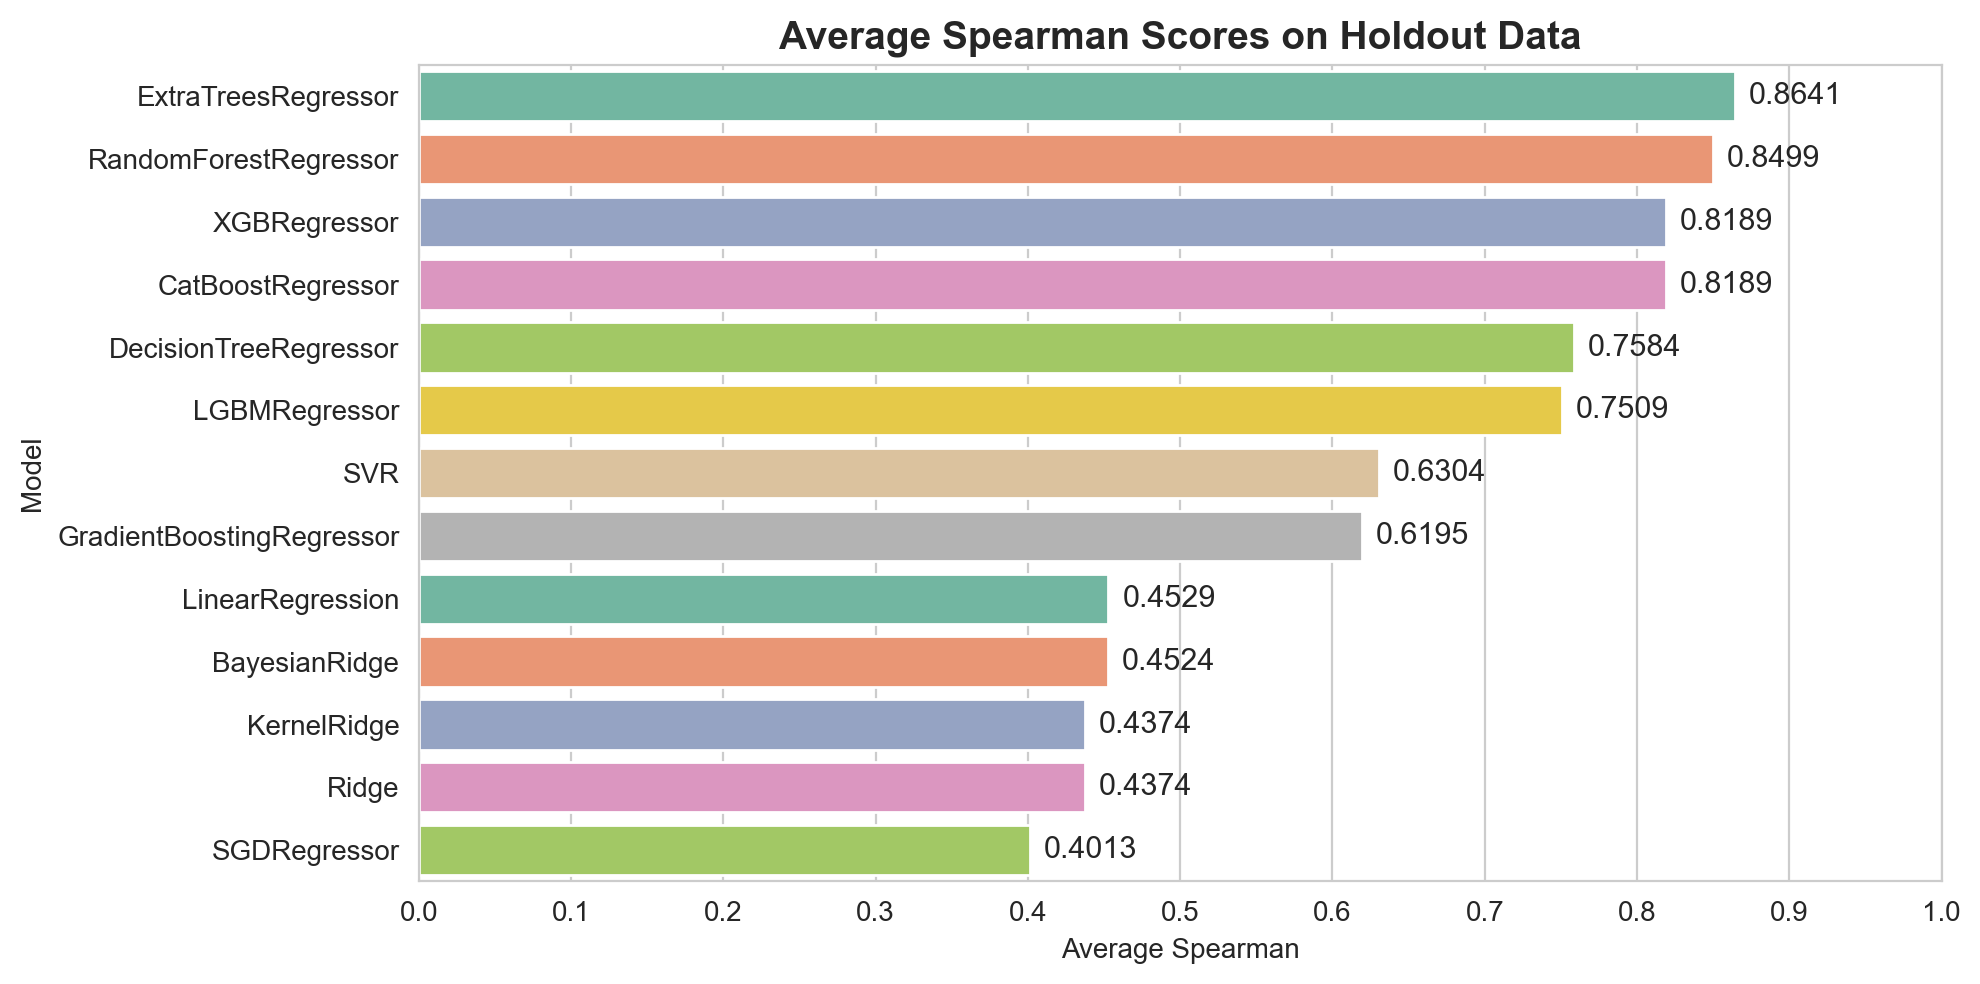

In [198]:
# plot scores
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="average_spearman", y="model", data=scores_df, ax=ax, palette="Set2")
ax.bar_label(ax.containers[0], fmt="%.4f", size=11, padding=5)
ax.set_title("Average Spearman Scores on Holdout Data", size=14, fontweight="bold")
ax.set_xlabel("Average Spearman")
ax.set_ylabel("Model")
ax.set_xticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()
plt.show()